In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import metrics
import category_encoders as ce

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
# checking Missing values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


<AxesSubplot: xlabel='HeartDisease', ylabel='count'>

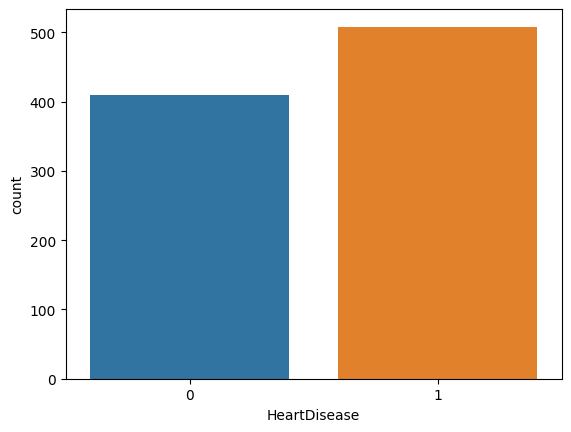

In [5]:
sns.countplot(x = df.HeartDisease)

In [6]:
df.head(10).style.background_gradient(cmap="Reds")

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500000,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000000,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.000000,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.000000,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.000000,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.500000,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.000000,Up,0


In [7]:
df.groupby('HeartDisease')['ST_Slope'].value_counts(normalize = True)

HeartDisease  ST_Slope
0             Up          0.773171
              Flat        0.192683
              Down        0.034146
1             Flat        0.750000
              Up          0.153543
              Down        0.096457
Name: ST_Slope, dtype: float64

#  Data Visulaisation

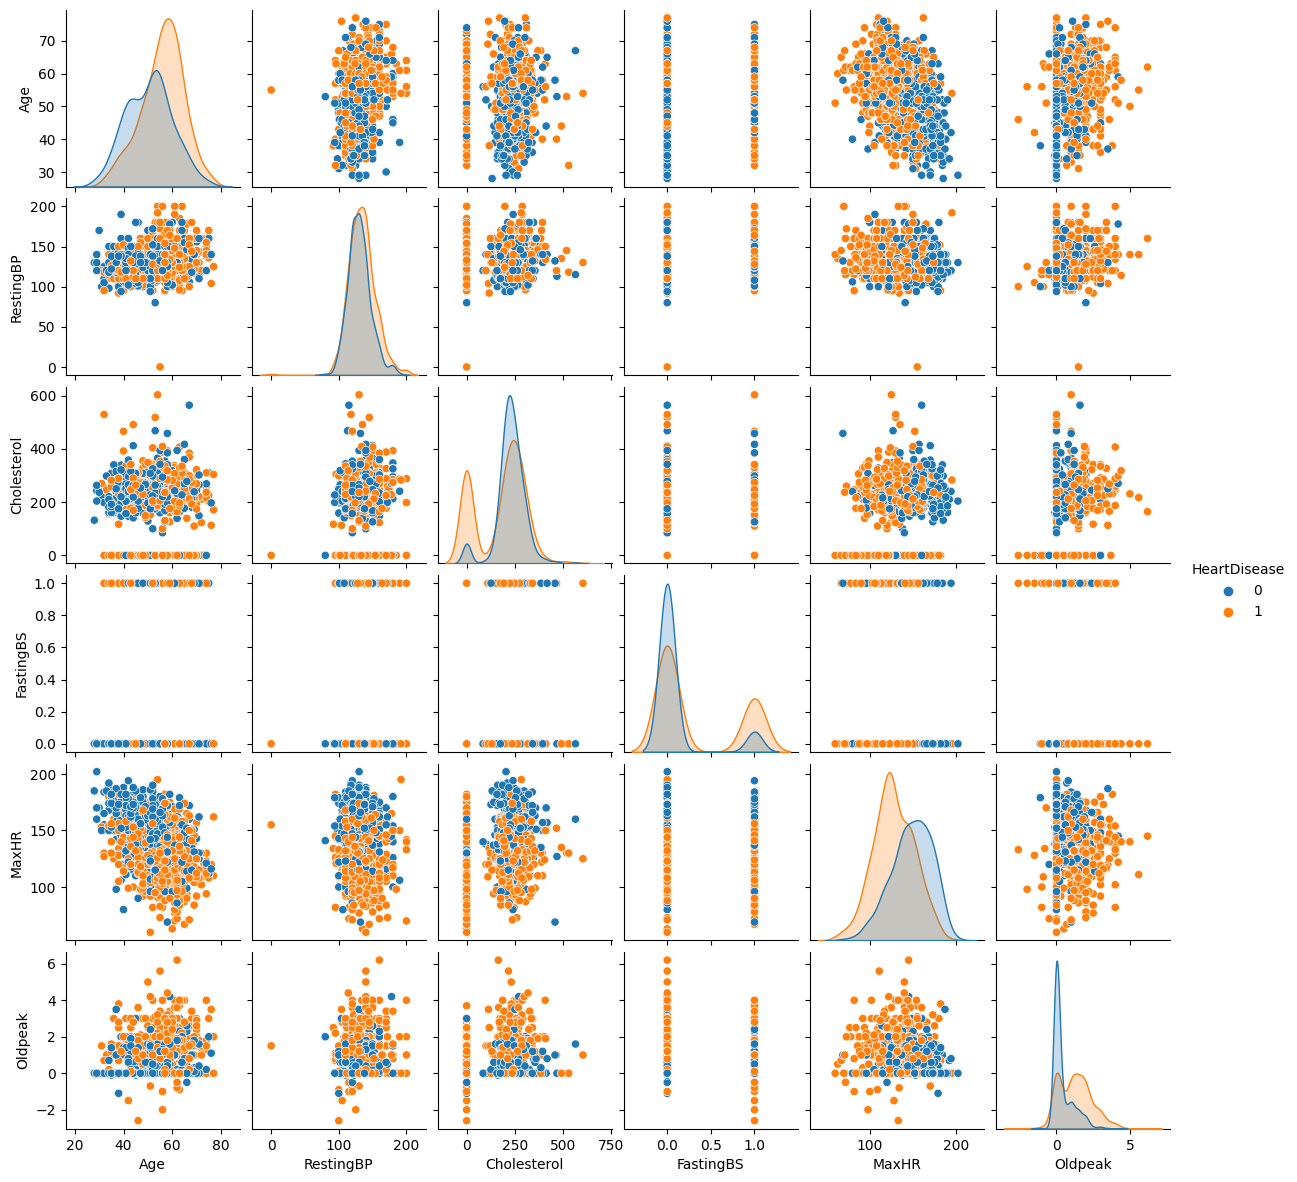

In [9]:
sns.pairplot(df,hue = 'HeartDisease', height = 2)

In [10]:
df[df.RestingBP == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [11]:
df.drop(index = 449, inplace = True)

# Data Preprocessing

In [14]:
# Here we replace ExerciseAngina values 'Y' and 'N' with True or False.
df["ExerciseAngina"] = df["ExerciseAngina"].apply(lambda x: 1 if x=="Y" else 0)

In [15]:
# Rename the Sex column to Male with True or False values (heart disease is known to be a leading cause of death for men).
df.Sex = df.Sex =='M'
df.rename(columns = {'Sex':'Male'}, inplace = True)

Let's use Target Encoder to encode the three remaining categorical features.

In [16]:
encoder = ce.TargetEncoder()
features = ['ChestPainType', 'RestingECG', 'ST_Slope']
df[features] = encoder.fit_transform(df[features], df['HeartDisease'])

# Correlation

In [17]:
corr = df.corr().HeartDisease.sort_values(ascending = False)
corr = corr.to_frame()
corr.style.background_gradient(cmap="Reds")

,HeartDisease
HeartDisease,1.000000
ST_Slope,0.622334
ChestPainType,0.541500
Oldpeak,0.403638
Male,0.305118
Age,0.282012
FastingBS,0.267994
RestingBP,0.117990
RestingECG,0.109870
Cholesterol,-0.231479


#  Feature distribution

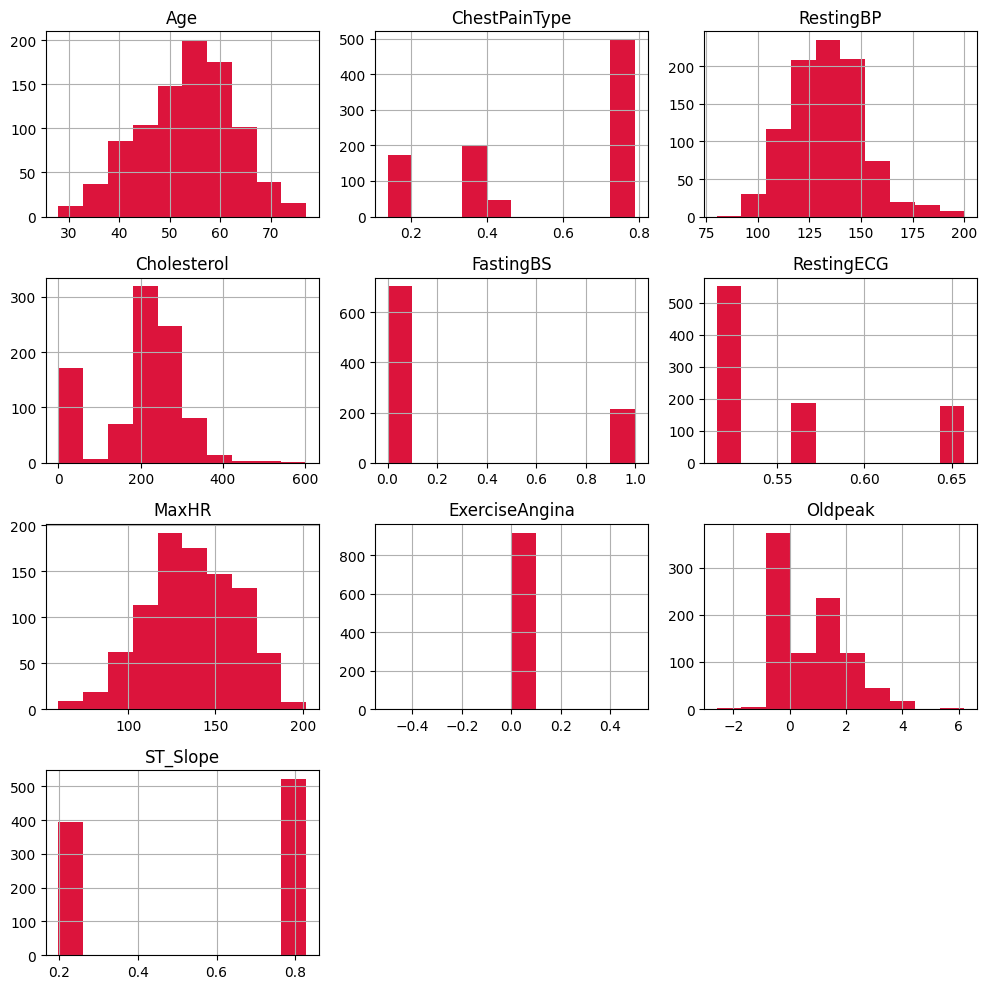

In [18]:
df.drop(columns = 'HeartDisease').hist(figsize=(10,10), grid = True, color = 'crimson')
plt.tight_layout()

# Prepare features and target

In [19]:
# Create the feature set by dropping the target column.
X = df.drop(columns = 'HeartDisease')

In [20]:
print("Features = ", [feature for feature in X.columns])
print('')
print("Number of features = ", len(X.columns))

Features =  ['Age', 'Male', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

Number of features =  11


In [21]:
y = df ['HeartDisease']

# Train and fit classifier

In [22]:
# Train and fit the classifier using early stopping rounds to address overfitting.

In [23]:
clf= xgb.XGBClassifier(n_estimators=1000,learning_rate=0.05,use_label_encoder=False )

C:\Users\SOUMEN MONDAL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 67)

In [25]:
clf.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

C:\Users\SOUMEN MONDAL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [26]:
clf.best_iteration

89

Now we refit the model to make some predictions using the best n_estimator.

In [27]:
clf= xgb.XGBClassifier(n_estimators = clf.best_iteration, random_state = 73,use_label_encoder=False )

In [29]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=89, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=73, ...)

# Feature importances

In [30]:
# Most important features according to this model.

In [31]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

ST_Slope          0.478468
ChestPainType     0.159619
Male              0.099763
FastingBS         0.051016
Oldpeak           0.043851
Cholesterol       0.037732
RestingECG        0.032841
RestingBP         0.032777
MaxHR             0.032567
Age               0.031368
ExerciseAngina    0.000000
dtype: float32

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


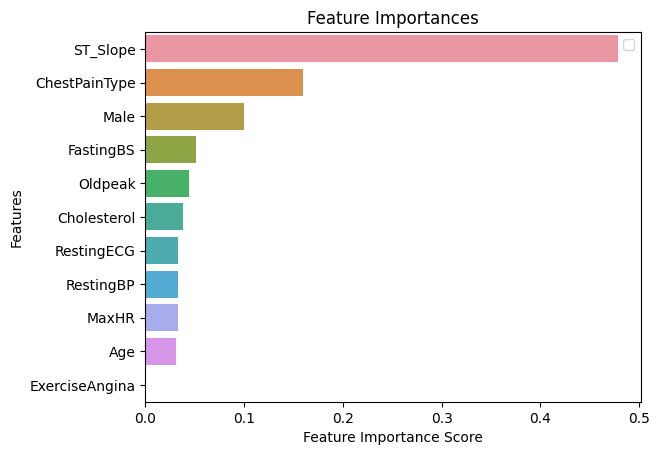

In [32]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importances")
plt.legend()
plt.show()

 Permutation importance orders the most important predictive features slightly differently

In [33]:
perm = PermutationImportance(clf, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.1852 ± 0.0252,ST_Slope
0.0926 ± 0.0089,ChestPainType
0.0716 ± 0.0149,Cholesterol
0.0638 ± 0.0131,Oldpeak
0.0393 ± 0.0156,Male
0.0390 ± 0.0089,MaxHR
0.0390 ± 0.0095,RestingBP
0.0335 ± 0.0110,Age
0.0146 ± 0.0066,RestingECG
0.0140 ± 0.0070,FastingBS


# ROC-AUC

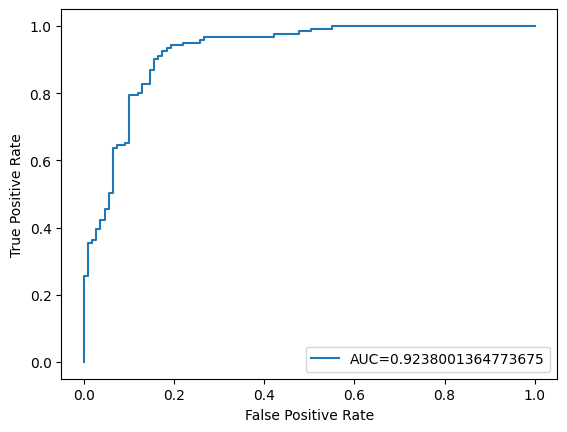

In [34]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# roc curve with AUC score
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Model Score

In [35]:
clf.score(X_test,y_test).round(2)

0.87